# 宿題10に対する補足説明

## モジュール読み込み

In [1]:
! pip install control
from pylab import *
import math
import cmath
import numpy as np
import pandas as pd
import control
import control.matlab as matlab
import matplotlib.pyplot as plt
%matplotlib inline

## 関数定義

In [2]:
def zeta_from_pos(pos):
    zeta = -1*math.log(pos/100) / math.sqrt(math.pi**2 + math.log(pos/100)**2)
    return zeta

In [3]:
def phim_from_zeta(zeta):
    phim = math.atan(2*zeta/math.sqrt(-2* zeta**2 + math.sqrt(1+4* zeta**4)))
    return np.rad2deg(phim)


In [4]:
def visualize_step(sys_dict):
    TIME_MAX = 20
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(1, 1, 1)
    plt.plot(list(np.arange(-10, 0+1))+list(np.arange(1, TIME_MAX+1)),
             [0]*len(np.arange(-10, 0+1))+[1]*len(np.arange(1, TIME_MAX+1)), 
             '-.', color='gray', label='Step input')
    for i, (label, sys) in enumerate(sys_dict.items()):
        output, time_list = matlab.step(sys, arange(0, TIME_MAX, 0.1))
        plt.plot(time_list, output, '--', label=label, linewidth=3.0/(i+1))

    plt.xlabel('Time second')
    plt.ylabel('Response p.u.')
    plt.grid()
    plt.legend(framealpha=0.1)
    plt.show()


In [5]:
def visualize_bode(sys_dict):
    res_dict = {}
    for label, sys in sys_dict.items():
        mag, phase, omega = control.bode(sys, dB=True, label=label)
        tmp_df = pd.DataFrame(np.array([np.rad2deg(phase),
                                        list(map(lambda v: 20*math.log10(v), mag))]).T,
                              index=omega, columns=['phase', 'mag'])
        tmp_df.index.name = 'omega'
        res_dict[label] = tmp_df.copy()
    plt.legend()
    plt.show()
    return res_dict

## 開ループ伝達関数定義

開ループ(一巡)伝達関数を，ゲイン$K$を除き次の通り定義する．

In [6]:
s = matlab.TransferFunction.s
G_without_gainK = 76.32 / (s*(s+150)*(s+1.32))
G_without_gainK

TransferFunction(array([76.32]), array([  1.  , 151.32, 198.  ,   0.  ]))

## ゲインK=1の場合

In [7]:
sys_dict = {}
for K in np.arange(1, 1 + 1, 1e+0):
    sys_dict[f'K: {int(K)}'] = G_without_gainK*K
sys_dict

{'K: 1': TransferFunction(array([76.32]), array([  1.  , 151.32, 198.  ,   0.  ]))}

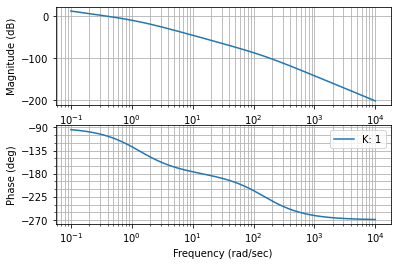

In [8]:
res_dict = visualize_bode(sys_dict)

In [9]:
pos_1 = 15 # 15%OS
zeta_1 = zeta_from_pos(pos_1)
phim_1 = phim_from_zeta(zeta_1)
phi = -1*(180 - phim_1)

print('zeta at 15%OS is ', round(zeta_1, 3))
print('Phi_m at the zeta is ', round(phim_1, 3))
print('phi at Phi_m is ', round(phi, 3))

zeta at 15%OS is  0.517
Phi_m at the zeta is  53.172
phi at Phi_m is  -126.828


In [10]:
tmp_df = res_dict['K: 1']
EPSILON = 1e-0
target_record = tmp_df[(phi - EPSILON <= tmp_df.phase) 
                       & (tmp_df.phase <= phi + EPSILON)]

target_record

,phase,mag
omega,,
0.946185,-125.994618,-9.600948
0.957152,-126.312041,-9.735287
0.968247,-126.630636,-9.870147
0.979470,-126.950370,-10.005532
0.990823,-127.271209,-10.141445
1.002308,-127.593119,-10.277891


## 最小二乗法による線形補間

In [11]:
from sklearn.linear_model import LinearRegression
model_omega_phase = LinearRegression()
model_omega_phase.fit(target_record.index.to_numpy().reshape(-1, 1), target_record.phase.tolist())
print('phase = a \omega +b, a: ', round(model_omega_phase.coef_[0], 3), ', b:', round(model_omega_phase.intercept_, 3))

phase = a \omega +b, a:  -28.482 , b: -99.049


In [12]:
model_omega_mag = LinearRegression()
model_omega_mag.fit(target_record.index.to_numpy().reshape(-1, 1), target_record.mag.tolist())
print('mag = a \omega +b, a: ', round(model_omega_phase.coef_[0], 3), ', b:', round(model_omega_phase.intercept_, 3))

mag = a \omega +b, a:  -28.482 , b: -99.049


In [13]:
target_omega = (phi - model_omega_phase.intercept_)/model_omega_phase.coef_[0]
print('omega: ', round(target_omega, 3), 'rad/s')

omega:  0.975 rad/s


In [14]:
target_M = model_omega_mag.coef_[0]*target_omega + model_omega_mag.intercept_
print('M: ', round(target_M, 3), 'dB')

M:  -9.954 dB


In [15]:
MY_K = 10**(-1*target_M/20)
         
print('Gain K:', round(MY_K, 3))

Gain K: 3.146


TransferFunction(array([240.06632393]), array([  1.  , 151.32, 198.  ,   0.  ]))

TransferFunction(array([76.32]), array([  1.  , 151.32, 198.  ,   0.  ]))

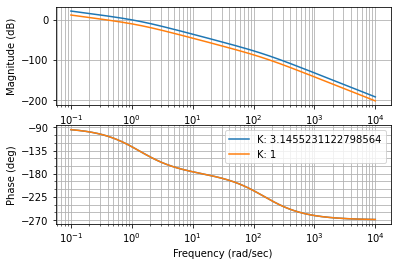

In [16]:
sys_dict = {}
for K in [MY_K, 1]:
    sys_dict[f'K: {K}'] = G_without_gainK*K
    display(sys_dict[list(sys_dict.keys())[-1]])
res_dict = visualize_bode(sys_dict)

TransferFunction(array([240.06632393]), array([  1.        , 151.32      , 198.        , 240.06632393]))

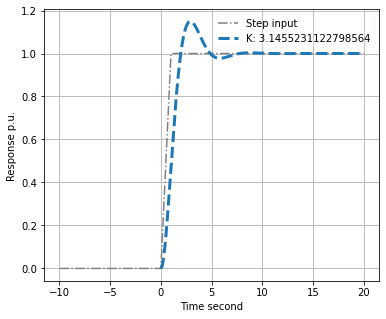

In [17]:
sys_dict = {}
for K in [MY_K]:
    sys_dict[f'K: {K}'] = matlab.feedback(G_without_gainK*K, 1)
    display(sys_dict[list(sys_dict.keys())[-1]])
visualize_step(sys_dict)